In [ ]:
import os
import pandas as pd

from qiskit.circuit import QuantumCircuit
import optuna
import qtpu
from qtpu.compiler.terminators import reach_num_qubits
from qtpu.compiler.compiler import find_least_cost_trial, trial_to_circuit

from benchmark._plot_util import *

In [ ]:
from benchmark.ansatz import qaoa1, qaoa2, generate_ansatz
from benchmark.util import get_info, append_to_csv
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from IPython.display import display
from optuna.visualization.matplotlib import plot_pareto_front


CSV = "tradeoff100.csv"

overheads = [1e5, 1e6, 1e7, 1e8, 1e9]

benchmarks = {
    "qml": generate_ansatz("zz", 100, 2),
    "qaoa1": qaoa1(7, 10, 2),
    "qaoa2": qaoa2(7, 10, 2),
    "vqe": generate_ansatz("linear", 100, 2),
}


results = {}

for name, bench in benchmarks.items():
    studies = []
    for overhead in overheads:
        study = qtpu.compiler.hyper_optimize(
            bench, max_cost=overhead, n_trials=200, choose_leaf_methods=["qubits"], show_progress_bar=True, 
        )
        studies.append(study)

        for trial in study.best_trials:
            trial = trial_to_circuit(trial)
            append_to_csv(CSV, {"name": name, "overhead": overhead, **get_info(trial)})

    results[name] = studies



    # append_to_csv(CSV, {"name": name, "overhead": overhead, **info})

[[70, 71], [72, 73], [74, 75], [76, 77], [78, 79], [80, 81]]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

[W 2024-08-13 17:28:52,044] Trial 98 failed with parameters: {'compress': 'qubits', 'choose_leaf': 'qubits', 'random_strength': 5.848101150241657, 'weight_edges': 'log', 'imbalance': 0.8478598086853602, 'imbalance_decay': 0.06807291300797225, 'parts': 11, 'parts_decay': 0.18270200427645023, 'mode': 'recursive', 'objective': 'cut', 'fix_output_nodes': 'auto'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/di75piq/qtpu/.venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/home/di75piq/qtpu/qtpu/compiler/compiler.py", line 118, in <lambda>
    lambda trial: objective(
                  ^^^^^^^^^^
  File "/home/di75piq/qtpu/qtpu/compiler/compiler.py", line 192, in objective
    subcircs = subcircuits(circuit)
               ^^^^^^^^^^^^^^^^^^^^
  File "/home/di75piq/qtpu/qtpu/circuit.py", line 56, in subcircuits
    circuit = _

KeyboardInterrupt: 

In [ ]:
.

In [ ]:
studies = results["qml"]
# fig, axes = plt.subplots(1, len(studies), figsize=(15, 5))z


study = studies[0]
data = []

# Iterate over the best trials in the study
for trial in study.trials:
    # Get the circuit from the trial
    circuit = trial_to_circuit(trial)
    # Retrieve information from the circuit
    info = get_info(circuit)
    # Append the info dictionary to the list
    data.append({**info, "cost": trial.values[0]})

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(data, columns=["qtpu_cost_log10", "num_2q", "cost"])
df = df.sort_values("qtpu_cost_log10")

In [ ]:
def get_pareto_front(df: pd.DataFrame, x: str, y: str) -> pd.DataFrame:
    df = df.sort_values(x)
    pareto_front = df.copy()
    pareto_front[y] = df[y].cummin()
    pareto_front = pareto_front.drop_duplicates(y)
    return pareto_front

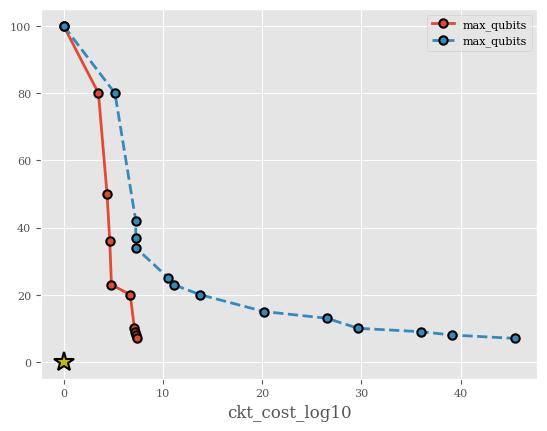

In [ ]:
df = pd.read_csv(CSV)
df = df[df["name"] == "qml"]
df["esp"] = 1 - df["esp"]

fig, ax = plt.subplots()

df1 = get_pareto_front(df, "qtpu_cost_log10", "max_qubits")
df2 = get_pareto_front(df, "ckt_cost_log10", "max_qubits")

df1.plot(x="qtpu_cost_log10", y="max_qubits", style="o-", ax=ax)
df2.plot(x="ckt_cost_log10", y="max_qubits", style="o--", ax=ax)
#make a yellow star at 0, 0
ax.plot(0, 0, "y*", markersize=15)
fig;

In [ ]:
get_pareto_front(df, "qtpu_cost_log10", "esp").plot(x="qtpu_cost_log10", y="esp", style="o-")

/tmp/ipykernel_563331/2600836115.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  plot_pareto_front(study, target_names=["qtpu_cost_log10", "num_2q"])


<Axes: title={'center': 'Pareto-front Plot'}, xlabel='qtpu_cost_log10', ylabel='num_2q'>

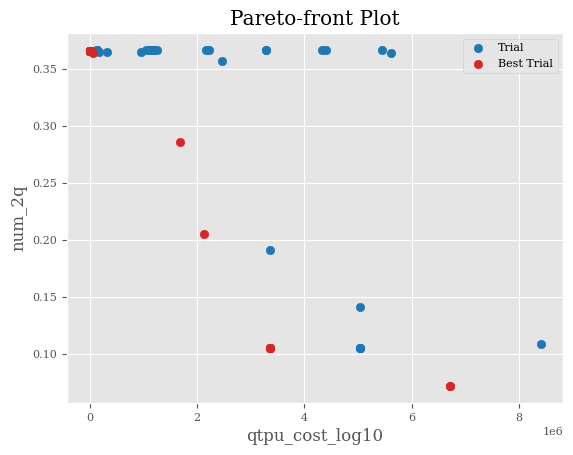

In [ ]:
plot_pareto_front(study, target_names=["qtpu_cost_log10", "num_2q"])

<Axes: xlabel='qtpu_cost_log10', ylabel='num_2q'>

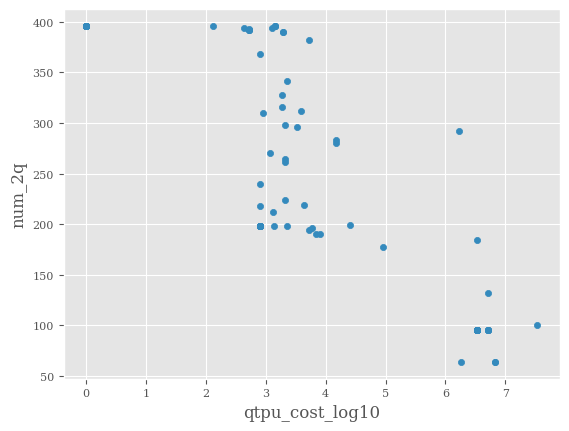

In [ ]:
df.plot(x="qtpu_cost_log10", y="num_2q", kind="scatter")

<Axes: xlabel='cost', ylabel='num_2q'>

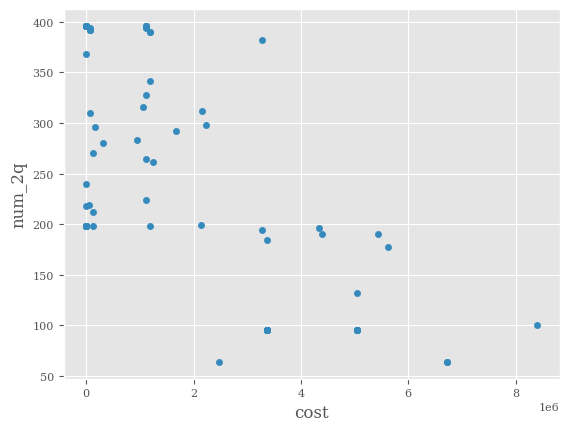

In [ ]:
df.plot(x="cost", y="num_2q", kind="scatter")

      calc_cost  qtpu_cost_log10  ckt_cost_log10  num_qpds  num_subcircuits  \
192         0.0         0.000000        0.000000         0                1   
193         0.0         0.000000        0.000000         0                1   
194         0.0         0.000000        0.000000         0                1   
195   8399376.0         7.531357       20.166992        24                7   
196         0.0         0.000000        0.000000         0                1   
..          ...              ...             ...       ...              ...   
270  16797456.0         7.226622       35.986843        44               12   
271  18477072.0         7.268008       39.136590        48               13   
272   5040144.0         6.703915       13.772639        16                5   
273   3360528.0         6.527946       10.541935        12                4   
274  13438224.0         7.129730       29.676203        36               10   

     num_instances  num_2q  max_qubits  depth    es

<Axes: xlabel='qtpu_cost_log10'>

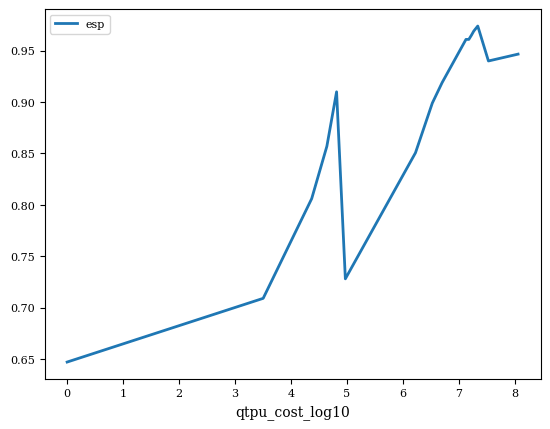

In [ ]:
df = pd.read_csv(CSV)

import numpy as np

df = df[df["name"] == "qml"].drop(columns=["name"])
print(df)
df1 = df.groupby("qtpu_cost_log10").mean().sort_index()
# df1["qtpu_cost"] = np.log(df1["qtpu_cost"])
# df1
# plot the df1 
fig, ax = plt.subplots()

df1.plot.line(ax=ax, y="esp")

# df2 = df.groupby("ckt_cost").mean().reset_index()
# df2["ckt_cost"] = np.log(df2["ckt_cost"])
# df2.plot.scatter(ax=ax, x="ckt_cost", y="esp")
# ax.set_xscale("log")

In [ ]:
def plot_pareto_front(study: optuna.Study, ax: plt.Axes) -> None:
    trials = set(tuple(trial.values) for trial in study.trials)
    best_trials = sorted(
        set(tuple(trial.values) for trial in study.best_trials),
        key=lambda x: (x[0], -x[1]),
    )
    non_optimal_trials = trials - set(best_trials)

    ax.plot(
        [vals[0] for vals in non_optimal_trials],
        [vals[1] for vals in non_optimal_trials],
        "x",
        # markeredgewidth=2,
        markersize=4,
        markeredgecolor="black",
        label="Non-optimal",
    )
    ax.plot(
        [vals[0] for vals in best_trials],
        [vals[1] for vals in best_trials],
        "o--",
        label="Pareto optimal",
        # color="red",
    )
    
        
    ax.set_xlabel("Contraction Cost")
    ax.set_ylabel("Success")

In [ ]:
# optuna.visualization.matplotlib.plot_contour(study, target=lambda t: t.values[1], params=["compress", "max_cost"])
# studies = studies[:1]
fig, axes = plt.subplots(1, len(studies), figsize=(5.5, 2))
axes = [axes] if len(studies) == 1 else axes
for ax, study in zip(axes, studies):
    plot_pareto_front(study, ax)
# ax.set_xscale("log")
# ax.set_xlim(-10000, 20000)
fig;

NameError: name 'studies' is not defined

In [ ]:
axes[0].set_ylabel("Max. Circuit Size")
axes[0].set_title("")
# set xlim to 4e9
axes[0].set_xlim(-.2e9, 3.5e9)

fig.set_figwidth(4.5)

fig.tight_layout()
fig.savefig("pareto.pdf", bbox_inches="tight")